In [6]:
# %pip install razdel transformers datasets seqeval wandb

In [1]:
import random
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

superseed = 1
set_random_seed(superseed)

### Чтение данных

In [3]:
# логирование результатов
# import wandb
# wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: danessely. Use `wandb login --relogin` to force relogin


True

In [4]:
data = pd.read_csv("data/train_data/ner_data_train.csv")

In [5]:
data.head(5)

,video_info,entities
0,<НАЗВАНИЕ:> Агент 117: Из Африки с любовью — Р...,"{""label"":""локация""\,""offset"":26\,""length"":6\,""..."
1,<НАЗВАНИЕ:> Коленвал Инфинити Ку икс 56= 5.6 V...,"{""label"":""организация""\,""offset"":196\,""length""..."
2,<НАЗВАНИЕ:> ВЫЗОВ ДЕМОНА = Вызвал Серого Челов...,"{""label"":""название проекта""\,""offset"":12\,""len..."
3,<НАЗВАНИЕ:> Довоенная немецкая кирха в Калинин...,"{""label"":""не найдено""\,""offset"":162\,""length"":..."
4,"<НАЗВАНИЕ:> ""Спартаку"" помогли судьи? Локомоти...","{""label"":""команда""\,""offset"":13\,""length"":8\,""..."


In [4]:
# данные спарсены с Толоки, поэтому могут иметь проблемы с символами и их нужно избежать,
# удалить лишние '\' например, преобразовать из str в список dict-ов
import json
df = data.copy()
df['entities'] = df['entities'].apply(lambda l: l.replace('\,', ',')if isinstance(l, str) else l)
df['entities'] = df['entities'].apply(lambda l: l.replace('\\\\', '\\')if isinstance(l, str) else l)
df['entities'] = df['entities'].apply(lambda l: '[' + l + ']'if isinstance(l, str) else l)
df['entities'] = df['entities'].apply(lambda l: json.loads(l)if isinstance(l, str) else l)

In [5]:
df.head(3)

,video_info,entities
0,<НАЗВАНИЕ:> Агент 117: Из Африки с любовью — Р...,"[{'label': 'локация', 'offset': 26, 'length': ..."
1,<НАЗВАНИЕ:> Коленвал Инфинити Ку икс 56= 5.6 V...,"[{'label': 'организация', 'offset': 196, 'leng..."
2,<НАЗВАНИЕ:> ВЫЗОВ ДЕМОНА = Вызвал Серого Челов...,"[{'label': 'название проекта', 'offset': 12, '..."


In [7]:
# Теперь из наших данных нам нужно извлечь для каждого слова (токена) его тег (label) из разметки, чтобы потом предать в модель классификации токенов
from razdel import tokenize

def extract_labels(item):

    # воспользуемся удобным токенайзером из библиотеки razdel,
    # она помимо разбиения на слова, сохраняет важные для нас числа - начало и конец слова в токенах

    raw_toks = list(tokenize(item['video_info']))
    words = [tok.text for tok in raw_toks]
    # words = item['video_info']
    # присвоим для начала каждому слову тег 'О' - тег, означающий отсутствие NER-а
    word_labels = ['O'] * len(raw_toks)
    char2word = [None] * len(item['video_info'])
    # так как NER можем состаять из нескольких слов, то нам нужно сохранить эту инфорцию
    for i, word in enumerate(raw_toks):
        char2word[word.start:word.stop] = [i] * len(word.text)

    labels = item['entities']
    if isinstance(labels, dict):
        labels = [labels]
    if labels is not None:
        for e in labels:
            if e['label'] != 'не найдено':
                e_words = sorted({idx for idx in char2word[e['offset']:e['offset']+e['length']] if idx is not None})
                if e_words:
                    word_labels[e_words[0]] = 'B-' + e['label']
                    for idx in e_words[1:]:
                        word_labels[idx] = 'I-' + e['label']
                else:
                    continue
            else:
                continue
        return {'tokens': words, 'tags': word_labels}
    else: return {'tokens': words, 'tags': word_labels}

In [8]:
print(extract_labels(df.iloc[0]))

{'tokens': ['<', 'НАЗВАНИЕ', ':', '>', 'Агент', '117', ':', 'Из', 'Африки', 'с', 'любовью', '—', 'Русский', 'тизер', '=', 'трейлер', '(', '2021', ')', '<', 'ОПИСАНИЕ', ':', '>', 'Лучший', 'Telegram', 'канал', 'о', 'кино', '<', 'LINK', '>', 'Сотрудничество', '<', 'LINK', '>', 'Дата', 'выхода', '26', 'августа', '2021', 'Оригинальное', 'название', ':', 'OSS', '117', ':', 'Alerte', 'rouge', 'en', 'Afrique', 'noire', 'Страна', ':', 'Франция', 'Режиссер', ':', 'Николя', 'Бедос', 'Жанр', ':', 'боевик', ',', 'комедия', 'В', 'главных', 'ролях', ':', 'Жан', 'Дюжарден', ',', 'Пьер', 'Нинэ', ',', 'Мелоди', 'Каста', ',', 'Наташа', 'Линдинжер', ',', 'Владимир', 'Иорданов', ',', 'Фату', 'Н', '’', 'Диайе', ',', 'Пол', 'Уайт', 'Мир', 'изменился', '.', 'Он', 'нет', '.', 'Судьба', 'заносит', 'легендарного', 'Агента', '117', 'в', 'Африку', ',', 'где', 'горячее', 'пустыни', 'только', 'женщины', '.', 'Вооруженный', 'неиссякаемой', 'уверенностью', 'в', 'себе', 'и', 'убийственной', 'харизмой', ',', 'он', 'мож

### Разбивка данных

In [10]:
from sklearn.model_selection import train_test_split
ner_data = [extract_labels(item) for i, item in df.iterrows()]
ner_train, ner_test = train_test_split(ner_data, test_size=0.2, random_state=superseed)

In [11]:
import pandas as pd
pd.options.display.max_colwidth = 300
pd.DataFrame(ner_train).sample(3, random_state=superseed)

,tokens,tags
3035,"[<, НАЗВАНИЕ, :, >, Убрался, в, дерево, ., Что, случилось, за, кадром, ?, Новогодний, конкурс, <, ОПИСАНИЕ, :, >, Условия, конкурса, просты, :, Для, Вконтакте, сделать, репост, этой, записи, (, <, LINK, >, 71769372_33169, ), Для, YouTube, написать, в, комментариях, #, дедебашит, Аренда, авто, Кр...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-организация, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
1714,"[<, НАЗВАНИЕ, :, >, Так, в, России, не, учат, ,, новая, школа, программирования, от, Сбера, <, ОПИСАНИЕ, :, >, Не, так, много, людей, знает, что, такое, Школа, 21, (, School, 21, ), ,, кто, то, слышал, ,, но, по, прежнему, возникает, много, вопросов, :, как, учат, ,, как, попасть, ,, что, получи...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-организация, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-организация, O, B-организация, I-организация, O, O, O, O, B-персона, O, O, O, O, B-локация, O, O, O, O, B-п..."
280,"[<, НАЗВАНИЕ, :, >, КАНАН, АББАСОВ, =, ИНТЕРВЬЮ, с, актёром, сериала, "", ДИАГНОЗ, "", (, часть, 2, ), 😳, <, ОПИСАНИЕ, :, >, Интервью, с, актёром, моего, проекта, сериала, на, Rutube, "", Диагноз, "", Кананом, Аббасовым, как, проходили, съёмки, ?, какие, были, сложности, ?, жалеет, ли, Вадим, об, уч...","[O, O, O, O, B-персона, I-персона, O, O, O, O, O, O, B-название проекта, O, O, O, B-сезон, O, O, O, O, O, O, O, O, O, O, O, O, O, B-бренд, O, B-название проекта, I-название проекта, B-персона, I-персона, O, O, O, O, O, O, O, O, O, O, B-персона, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [12]:
label_list = sorted({label for item in ner_train for label in item['tags']})
if 'O' in label_list:
    label_list.remove('O')
    label_list = ['O'] + label_list
label_list

['O',
 'B-Дата',
 'B-бренд',
 'B-вид спорта',
 'B-видеоигра',
 'B-команда',
 'B-лига',
 'B-локация',
 'B-модель',
 'B-название проекта',
 'B-организация',
 'B-персона',
 'B-сезон',
 'B-серия',
 'I-Дата',
 'I-бренд',
 'I-вид спорта',
 'I-видеоигра',
 'I-команда',
 'I-лига',
 'I-локация',
 'I-модель',
 'I-название проекта',
 'I-организация',
 'I-персона',
 'I-сезон',
 'I-серия']

In [14]:
labels_to_ids = {v:k for k,v in enumerate(label_list)}
ids_to_labels = {k:v for k,v in enumerate(label_list)}

In [15]:
class NERDataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len=512):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        tokens = self.data.tokens[index]
        word_labels = self.data.tags[index]

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        tokenized_inputs = self.tokenizer(tokens, truncation=True,
                                     is_split_into_words=True,
                                     padding='max_length',
                                     max_length=self.max_len)

        # step 3: create token labels only for first word pieces of each tokenized word
        # pdb.set_trace()
        labels = [labels_to_ids[label] for label in word_labels]
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        # print(len(sentence), len(labels))

        word_ids = tokenized_inputs.word_ids()
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(labels[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(labels[word_idx])
            previous_word_idx = word_idx

        label_ids = [label_list.index(idx) if isinstance(idx, str) else idx for idx in label_ids]

        item = {key: torch.as_tensor(val) for key, val in tokenized_inputs.items()}
        item['labels'] = torch.as_tensor(label_ids)

        return item

  def __len__(self):
        return self.len

### Выбор модели

In [16]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, BertModel, BertConfig
from datasets import load_metric

In [17]:
# model_checkpoint = "ai-forever/ruBert-base"
model_checkpoint = "cointegrated/rubert-tiny"

In [18]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, device=device)

In [19]:
train_set = NERDataset(pd.DataFrame(ner_train), tokenizer=tokenizer)
test_set = NERDataset(pd.DataFrame(ner_test), tokenizer=tokenizer)

print("FULL Dataset: {}".format(len(ner_train) + len(ner_test)))
print("TRAIN Dataset: {}".format(len(ner_train)))
print("TEST Dataset: {}".format(len(ner_test)))

FULL Dataset: 6422
TRAIN Dataset: 5137
TEST Dataset: 1285


In [20]:
train_params = {'batch_size': 4,
                'shuffle': True,
                }

test_params = {'batch_size': 8,
                'shuffle': False,
                }

train_loader = DataLoader(train_set, **train_params)
test_loader = DataLoader(test_set, **test_params)

In [21]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized f

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elem

In [22]:
# проверка выхода
model.to(device)
inputs = next(iter(train_loader))
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]
labels = inputs["labels"]

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

outputs = model(input_ids, attention_mask=attention_mask, labels=labels,
               return_dict=False)
initial_loss = outputs[0]
initial_loss

tensor(3.4282, device='cuda:0', grad_fn=<NllLossBackward0>)

### Кастомные модели

In [23]:
class CustomHead(nn.Module):
    """
    A pre-trained BERT model with a custom classifier.
    The classifier is a neural network implemented in this class.
    """
    
    def __init__(self, model_checkpoint, hidden_dim, num_labels):
        super().__init__()
        self.bert = BertConfig.from_pretrained(model_checkpoint)
        self.in_features = self.bert.hidden_size

        self.model = nn.Sequential(
            nn.Linear(in_features=self.in_features, out_features=hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            # nn.BatchNorm1d(num_features=hidden_dim),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=num_labels)
        )

        
    def forward(self, bert_output):
        x = bert_output
        return self.model(x)

In [25]:
custom_classifier = CustomHead(model_checkpoint, 512, 27)
custom_model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
custom_model.classifier = custom_classifier

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized f

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elem

In [26]:
custom_model.to(device)
inputs = next(iter(train_loader))
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]
labels = inputs["labels"]

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

outputs = custom_model(input_ids, attention_mask=attention_mask, labels=labels,
               return_dict=True)
initial_loss = outputs[0]
initial_loss

tensor(3.3092, device='cuda:0', grad_fn=<NllLossBackward0>)

### Кастомный bertclass

In [86]:
from transformers import BertForTokenClassification

In [101]:
in_features = 312
latent_head_dim = 256
num_labels = 27

class BertTokenClassHead(BertForTokenClassification):
    def __init__(self, config):
        super().__init__(config)
        self.classifier = nn.Linear(in_features=in_features, out_features=num_labels)
        # self.classifier = nn.Sequential(
            # nn.Linear(in_features=in_features, out_features=latent_head_dim),
            # nn.ReLU(),
            # nn.Dropout(p=0.3),
            # nn.BatchNorm1d(num_features=latent_head_dim),
            # nn.Linear(in_features=latent_head_dim, out_features=latent_head_dim),
            # nn.ReLU(),
            # nn.Linear(in_features=latent_head_dim, out_features=num_labels)
        # )


In [102]:
custom_model = BertTokenClassHead.from_pretrained(model_checkpoint, num_labels=len(label_list))

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertTokenClassHead: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertTokenClassHead from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertTokenClassHead from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertTokenClassHead were not initialized from the model checkpoint at coin

BertTokenClassHead(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_

In [89]:
custom_model.to(device)
inputs = next(iter(train_loader))
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]
labels = inputs["labels"]

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

outputs = custom_model(input_ids, attention_mask=attention_mask, labels=labels,
               return_dict=True)
initial_loss = outputs[0]
initial_loss

tensor(3.2844, device='cuda:0', grad_fn=<NllLossBackward0>)

### метрика

In [27]:
from sklearn.metrics import f1_score
metric = load_metric("seqeval")

C:\Users\hdyst\AppData\Local\Temp\ipykernel_45384\1804829960.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [28]:
example = ner_train[1]
metric.compute(predictions=[example['tags']], references=[example['tags']])
metric.compute(predictions=[example['tags']], references=[example['tags']])['overall_f1']

1.0

### trainloop

In [29]:
def train_epoch(train_loader, optimizer, model):
    tr_loss, tr_accuracy_seq, tr_accuracy_skl = 0, 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    set_random_seed(superseed)
    for idx, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels,
                               return_dict=False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)

        if idx % 200==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 200 training steps: {loss_step}")

        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))

        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        labels_str = [ids_to_labels[id.item()] for id in labels]
        predictions_str = [ids_to_labels[id.item()] for id in predictions]
        metric_dict = metric.compute(predictions=[predictions_str], references=[labels_str], zero_division=0)
        tmp_tr_accuracy_seq = metric_dict['overall_f1']
        tr_accuracy_seq += tmp_tr_accuracy_seq
        
        # metrics = {
        #     'train/loss': loss.item(),
        #     'train/f1': tmp_tr_accuracy_seq
        # }
        # wandb.log(metrics)

        # tmp_tr_accuracy_skl = f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')
        # tr_accuracy_skl += tmp_tr_accuracy_skl

        # gradient clipping
        # torch.nn.utils.clip_grad_norm_(
        #     parameters=model.parameters(), max_norm=10
        # )

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy_seq = tr_accuracy_seq / nb_tr_steps
    # tr_accuracy_skl = tr_accuracy_skl / nb_tr_steps

    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training seqeval F1 epoch: {tr_accuracy_seq}")
    # print(f"Training sklearn F1 epoch: {tr_accuracy_skl}")
    return epoch_loss, tr_accuracy_seq

In [30]:
def valid_epoch(testing_loader, model):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy_seq, eval_accuracy_skl = 0, 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    set_random_seed(superseed)
    with torch.no_grad():
        for idx, batch in tqdm(enumerate(testing_loader), total=len(testing_loader)):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels,
                                     return_dict=False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            # tmp_eval_accuracy = f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='micro')
            labels_str = [ids_to_labels[id.item()] for id in labels]
            predictions_str = [ids_to_labels[id.item()] for id in predictions]
            metric_dict = metric.compute(predictions=[predictions_str], references=[labels_str], zero_division=0)
            tmp_eval_accuracy_seq = metric_dict['overall_f1']
            eval_accuracy_seq += tmp_eval_accuracy_seq

            
            # tmp_eval_accuracy_skl = f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')
            # eval_accuracy_skl += tmp_eval_accuracy_skl


    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy_seq = eval_accuracy_seq / nb_eval_steps
    # eval_accuracy_skl = eval_accuracy_skl / nb_eval_steps

    # metrics = {
    #     'val/loss': eval_loss,
    #     'val/f1': eval_accuracy_seq
    # }
    # wandb.log(metrics)

    print(f"Validation Loss: {eval_loss}")
    print(f"Validation seqeval F1: {eval_accuracy_seq}")
    # print(f"Validation sklearn F1: {eval_accuracy_skl}")

    # return labels, predictions
    return eval_loss, eval_accuracy_seq

In [31]:
def plot_losses(train_losses, test_losses, train_metrics, test_metrics):
    # clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    axs[1].plot(range(1, len(test_metrics) + 1), test_metrics, label='test')
    axs[1].set_ylabel('metric')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [32]:
def train(
    train_loader, test_loader, num_epoch,
    optimizer, model, scheduler=None
    ):

    train_losses, test_losses = [], []
    train_metrics, test_metrics = [], []

    for i in range(1, num_epoch + 1):
        print(f'Epoch {i}:')
        set_random_seed(superseed)
        train_loss, train_metric = train_epoch(train_loader, optimizer, model)
        train_losses.append(train_loss)
        train_metrics.append(train_metric)

        test_loss, test_metric = valid_epoch(test_loader, model)
        test_losses.append(test_loss)
        test_metrics.append(test_metric)

        if scheduler is not None:
            scheduler.step()
    plot_losses(train_losses, test_losses, train_metrics, test_metrics)
    return test_metrics[-1]
    # return (train_losses, test_losses, train_metrics, test_metrics)


### train

In [33]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
model.to(device)


lr = 0.0001
num_epoch = 10
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized f

Epoch 1:


0it [00:00, ?it/s]

Training loss per 200 training steps: 3.5208935737609863
Training loss per 200 training steps: 0.7627789848182925
Training loss per 200 training steps: 0.6599704498736341
Training loss per 200 training steps: 0.6006262226405239
Training loss per 200 training steps: 0.5795157675941786
Training loss per 200 training steps: 0.5535571421389575
Training loss per 200 training steps: 0.5401108090228384
Training loss epoch: 0.5337778072064953
Training seqeval F1 epoch: 0.15254751436801298


0it [00:00, ?it/s]

Validation loss per 100 evaluation steps: 0.2563433349132538
Validation loss per 100 evaluation steps: 0.44733508595145577
Validation Loss: 0.42935955107952495
Validation seqeval F1: 0.3147797760609236
Epoch 2:


0it [00:00, ?it/s]

Training loss per 200 training steps: 1.3039171695709229
Training loss per 200 training steps: 0.4166925603996462
Training loss per 200 training steps: 0.4016206601537077
Training loss per 200 training steps: 0.38164328101917033
Training loss per 200 training steps: 0.38253819004873213
Training loss per 200 training steps: 0.37366433583058556
Training loss per 200 training steps: 0.37142804384752676
Training loss epoch: 0.36907597801100883
Training seqeval F1 epoch: 0.34222463572963596


0it [00:00, ?it/s]

Validation loss per 100 evaluation steps: 0.24649126827716827
Validation loss per 100 evaluation steps: 0.421150746174378
Validation Loss: 0.4027612487906995
Validation seqeval F1: 0.36987492187156473
Epoch 3:


0it [00:00, ?it/s]

Training loss per 200 training steps: 1.1517274379730225
Training loss per 200 training steps: 0.31756692287044147
Training loss per 200 training steps: 0.3037290720366629
Training loss per 200 training steps: 0.2867719690236395
Training loss per 200 training steps: 0.28641566186306183
Training loss per 200 training steps: 0.2793011789867928
Training loss per 200 training steps: 0.27786923106216965
Training loss epoch: 0.27554562654244763
Training seqeval F1 epoch: 0.4561504370500947


0it [00:00, ?it/s]

Validation loss per 100 evaluation steps: 0.2782089114189148
Validation loss per 100 evaluation steps: 0.46504536979269273
Validation Loss: 0.4449916298715224
Validation seqeval F1: 0.36645317830965446
Epoch 4:


0it [00:00, ?it/s]

Training loss per 200 training steps: 0.961128294467926
Training loss per 200 training steps: 0.23164511968692145
Training loss per 200 training steps: 0.21968169342215518
Training loss per 200 training steps: 0.20905674050272305
Training loss per 200 training steps: 0.20870313182073214
Training loss per 200 training steps: 0.2034590251159507
Training loss per 200 training steps: 0.20216741351306836
Training loss epoch: 0.20059583769959002
Training seqeval F1 epoch: 0.5529792941904925


0it [00:00, ?it/s]

Validation loss per 100 evaluation steps: 0.3200785517692566
Validation loss per 100 evaluation steps: 0.5237427738928558
Validation Loss: 0.5066217825464581
Validation seqeval F1: 0.36298030055125546
Epoch 5:


0it [00:00, ?it/s]

Training loss per 200 training steps: 0.7134564518928528
Training loss per 200 training steps: 0.18320922192130515
Training loss per 200 training steps: 0.17029285343814446
Training loss per 200 training steps: 0.1652985208244768
Training loss per 200 training steps: 0.1649656370049633
Training loss per 200 training steps: 0.16082669103743283
Training loss per 200 training steps: 0.15899645177093796
Training loss epoch: 0.15771996706274813
Training seqeval F1 epoch: 0.6240571016613983


0it [00:00, ?it/s]

Validation loss per 100 evaluation steps: 0.37650033831596375
Validation loss per 100 evaluation steps: 0.575678012158611
Validation Loss: 0.5549553270850863
Validation seqeval F1: 0.36231920418031727
Epoch 6:


0it [00:00, ?it/s]

Training loss per 200 training steps: 0.5250911712646484
Training loss per 200 training steps: 0.13834041731422814
Training loss per 200 training steps: 0.13022977453273282
Training loss per 200 training steps: 0.12499508460652015
Training loss per 200 training steps: 0.12473490130802739
Training loss per 200 training steps: 0.12098773999733257
Training loss per 200 training steps: 0.12024434145383357
Training loss epoch: 0.11958542753061721
Training seqeval F1 epoch: 0.6911755081567316


0it [00:00, ?it/s]

Validation loss per 100 evaluation steps: 0.39679378271102905
Validation loss per 100 evaluation steps: 0.605706128448543
Validation Loss: 0.5833167622548453
Validation seqeval F1: 0.3739171790484688
Epoch 7:


0it [00:00, ?it/s]

Training loss per 200 training steps: 0.38046085834503174
Training loss per 200 training steps: 0.1121748860239686
Training loss per 200 training steps: 0.09964965416020957
Training loss per 200 training steps: 0.09260792802583842
Training loss per 200 training steps: 0.09306254000728544
Training loss per 200 training steps: 0.09095300549941768
Training loss per 200 training steps: 0.09009261867054719
Training loss epoch: 0.08959476586489246
Training seqeval F1 epoch: 0.7531557503972297


0it [00:00, ?it/s]

Validation loss per 100 evaluation steps: 0.4006583094596863
Validation loss per 100 evaluation steps: 0.6362751931837289
Validation Loss: 0.6109346601163378
Validation seqeval F1: 0.37673952117612014
Epoch 8:


0it [00:00, ?it/s]

Training loss per 200 training steps: 0.23495171964168549
Training loss per 200 training steps: 0.08094824396018217
Training loss per 200 training steps: 0.0723035404286777
Training loss per 200 training steps: 0.0682391579779711
Training loss per 200 training steps: 0.06942877115085302
Training loss per 200 training steps: 0.06827696665612558
Training loss per 200 training steps: 0.06875146575117767
Training loss epoch: 0.06831008594225846
Training seqeval F1 epoch: 0.8030499366813815


0it [00:00, ?it/s]

Validation loss per 100 evaluation steps: 0.4184955060482025
Validation loss per 100 evaluation steps: 0.6909505214431498
Validation Loss: 0.6676239452747085
Validation seqeval F1: 0.3780181948900491
Epoch 9:


0it [00:00, ?it/s]

Training loss per 200 training steps: 0.13428263366222382
Training loss per 200 training steps: 0.06042677749629452
Training loss per 200 training steps: 0.05685072895917493
Training loss per 200 training steps: 0.053750220674187714
Training loss per 200 training steps: 0.05617782545564336
Training loss per 200 training steps: 0.05532094032632059
Training loss per 200 training steps: 0.05538825989451932
Training loss epoch: 0.055788532701041914
Training seqeval F1 epoch: 0.8332836414754201


0it [00:00, ?it/s]

Validation loss per 100 evaluation steps: 0.4784061312675476
Validation loss per 100 evaluation steps: 0.7114893560952479
Validation Loss: 0.6820816932627873
Validation seqeval F1: 0.3611827321557024
Epoch 10:


0it [00:00, ?it/s]

Training loss per 200 training steps: 0.1459890604019165
Training loss per 200 training steps: 0.05074546429842933
Training loss per 200 training steps: 0.046643534386089244
Training loss per 200 training steps: 0.0443757149557848
Training loss per 200 training steps: 0.04586010670667856
Training loss per 200 training steps: 0.044774269263797836
Training loss per 200 training steps: 0.044003876705082455
Training loss epoch: 0.043931820830475206
Training seqeval F1 epoch: 0.8635667297752245


0it [00:00, ?it/s]

Validation loss per 100 evaluation steps: 0.4170237183570862
Validation loss per 100 evaluation steps: 0.746746301651001
Validation Loss: 0.7189348103096767
Validation seqeval F1: 0.37851566838570494


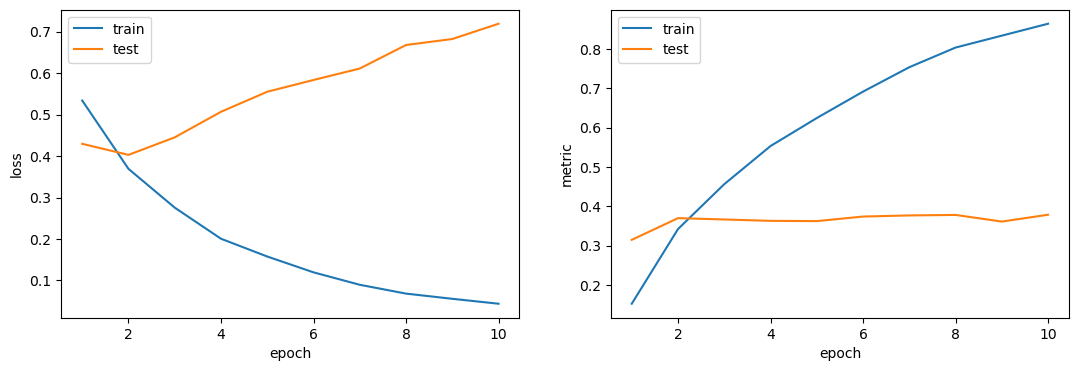

F1 on test: 0.37851566838570494


train/f1,▁▁▂▃▂▃▃▃▂▂▅▂▅▅▆▆▇▅▅▆▄▆▅▇▆▆▆▇▇▇▇▆▇▇▇▇█▅██
train/loss,█▄▄▆▃▃▃▃▃▂▂▅▂▂▂▂▁▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/f1,▁▇▇▆▆▇██▆█
val/loss,▂▁▂▃▄▅▆▇▇█
train/f1,1.0
train/loss,0.00189
val/f1,0.37852
val/loss,0.71893


In [34]:
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="dh-perm",
    
#     # track hyperparameters and run metadata
#     config={
#     "learning_rate": lr,
#     "optimizer": optimizer,
#     "scheduler": scheduler,
#     "model": "rubert-tiny-default",
#     "epochs": num_epoch,
#     }
# )


final_metric = train(train_loader, test_loader, num_epoch, optimizer, model)
# train_losses, test_losses, train_metrics, test_metrics = train(test_loader, test_loader, 1, optimizer, model)
print(f'F1 on test: {final_metric}')

# wandb.finish()

In [69]:
custom_classifier = CustomHead(model_checkpoint, hidden_dim=512, num_labels=len(label_list))
custom_model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
# custom_model.classifier = custom_classifier
custom_model.classifier = nn.Linear(in_features=312, out_features=27)
custom_model.to(device)
# for param in custom_model.bert.named_parameters():
#     param[1].requires_grad=False

num_epoch = 5
optimizer = torch.optim.Adam(params=custom_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized f

Epoch 1:


0it [00:00, ?it/s]

Training loss per 200 training steps: 3.5530459880828857
Training loss per 200 training steps: 2.2201057755531957
Training loss per 200 training steps: 1.600216706866338
Training loss per 200 training steps: 1.31441195465364
Training loss per 200 training steps: 1.1710765421688185
Training loss per 200 training steps: 1.0701394235784119
Training loss per 200 training steps: 1.0038728837689987
Training loss epoch: 0.9816905076981518
Training seqeval F1 epoch: 0.004982716502496525


0it [00:00, ?it/s]

Validation loss per 100 evaluation steps: 0.42408522963523865
Validation loss per 100 evaluation steps: 0.6403736050176149
Validation Loss: 0.6181838027438762
Validation seqeval F1: 0.027110893462392167
Epoch 2:


0it [00:00, ?it/s]

Training loss per 200 training steps: 1.393808126449585
Training loss per 200 training steps: 0.6215198753188499
Training loss per 200 training steps: 0.6105390973667849
Training loss per 200 training steps: 0.595470836748696
Training loss per 200 training steps: 0.6024584218245767
Training loss per 200 training steps: 0.5971512112703238
Training loss per 200 training steps: 0.5980299978232404
Training loss epoch: 0.5979121182447278
Training seqeval F1 epoch: 0.0430125104235617


0it [00:00, ?it/s]

Validation loss per 100 evaluation steps: 0.36463698744773865
Validation loss per 100 evaluation steps: 0.5805291371180279
Validation Loss: 0.5584464398044977
Validation seqeval F1: 0.08323984066834499
Epoch 3:


0it [00:00, ?it/s]

Training loss per 200 training steps: 1.3438550233840942
Training loss per 200 training steps: 0.5688982112194175
Training loss per 200 training steps: 0.5628634453785984
Training loss per 200 training steps: 0.5505680590867996
Training loss per 200 training steps: 0.5604898833975512
Training loss per 200 training steps: 0.5575326377605939
Training loss per 200 training steps: 0.5606105717691553
Training loss epoch: 0.5610639366774244
Training seqeval F1 epoch: 0.07626069811611458


0it [00:00, ?it/s]

Validation loss per 100 evaluation steps: 0.3418986201286316
Validation loss per 100 evaluation steps: 0.5560238657906504
Validation Loss: 0.5342510878484442
Validation seqeval F1: 0.11132377061985821
Epoch 4:


0it [00:00, ?it/s]

Training loss per 200 training steps: 1.3267227411270142
Training loss per 200 training steps: 0.5468810655139572
Training loss per 200 training steps: 0.5423014343825362
Training loss per 200 training steps: 0.5305060249894312
Training loss per 200 training steps: 0.5411869423294187
Training loss per 200 training steps: 0.5389130918549133
Training loss per 200 training steps: 0.5426807382534088
Training loss epoch: 0.543262777387632
Training seqeval F1 epoch: 0.095757961696805


0it [00:00, ?it/s]

Validation loss per 100 evaluation steps: 0.32975664734840393
Validation loss per 100 evaluation steps: 0.5422290063435489
Validation Loss: 0.5208126642504094
Validation seqeval F1: 0.13150712632687933
Epoch 5:


0it [00:00, ?it/s]

Training loss per 200 training steps: 1.3207308053970337
Training loss per 200 training steps: 0.5343633455349438
Training loss per 200 training steps: 0.5304778022621932
Training loss per 200 training steps: 0.5188099665694348
Training loss per 200 training steps: 0.529759525499317
Training loss per 200 training steps: 0.5277894391984372
Training loss per 200 training steps: 0.5318825697459646
Training loss epoch: 0.5325074262598145
Training seqeval F1 epoch: 0.10660473260994455


0it [00:00, ?it/s]

Validation loss per 100 evaluation steps: 0.32204410433769226
Validation loss per 100 evaluation steps: 0.5332987305551472
Validation Loss: 0.5121765585604662
Validation seqeval F1: 0.14208532845647992


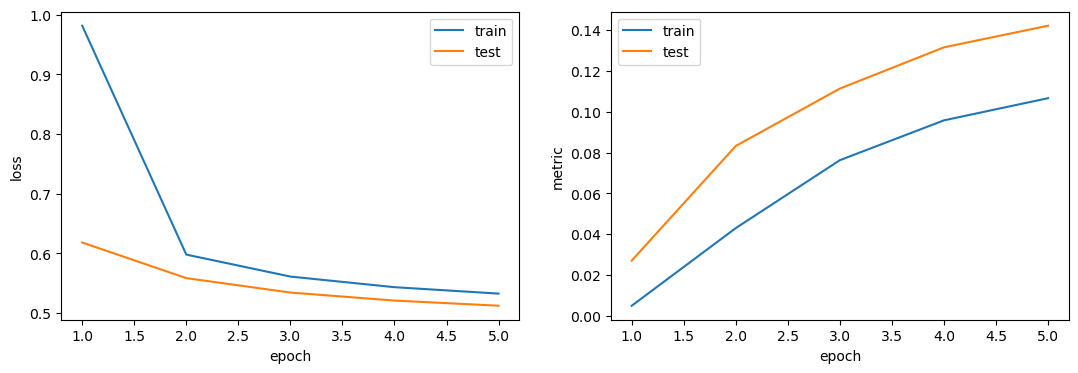

F1 on test: 0.14208532845647992


In [70]:
final_metric = train(train_loader, test_loader, num_epoch, optimizer, custom_model)
print(f'F1 on test: {final_metric}')

## че-то старое

#### У Bert свой собсвенный токенайзер, который разбивает слова на мелкие токены, поэтому нам нужно корректно сопоставить токены и соответсвующие им неры.

In [ ]:
# Посчитаем метрики на отложенном датасете

predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

In [ ]:
cm = pd.DataFrame(
    confusion_matrix(sum(true_labels, []), sum(true_predictions, []), labels=label_list),
    index=label_list,
    columns=label_list
)
cm

In [ ]:
model.save_pretrained('ner_bert.bin')
tokenizer.save_pretrained('ner_bert.bin')

### Посмотрим на результаты

In [ ]:
# text = ' '.join(ner_train[25]['tokens'])
text = ner_train[25]['tokens']

In [ ]:
import torch
from transformers import pipeline

pipe = pipeline(model=model, tokenizer=tokenizer, task='ner', aggregation_strategy='average', device='cpu')

def predict_ner(text, tokenizer, model, pipe, verbose=True):
    tokens = tokenizer(text, truncation=True, is_split_into_words=True, return_tensors='pt')
    tokens = {k: v.to(model.device) for k, v in tokens.items()}

    with torch.no_grad():
        pred = model(**tokens)
    # print(pred.logits.shape)
    indices = pred.logits.argmax(dim=-1)[0].cpu().numpy()
    token_text = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
    labels = []
    for t, idx in zip(token_text, indices):
        if '##' not in t:
            labels.append(label_list[idx])
        if verbose:
            print(f'{t:15s} {label_list[idx]:10s}')
    return text, pipe(text), labels

In [ ]:
predict_ner(text, tokenizer, model, pipe)

### Тестового датасета у вас пока нет, по которому будет считаться метрика на лидерборде, но прогоним для примера через нашу отложенную выборку, чтобы понять формат выходных данных.
ВАЖНО: в тестовом датасете у вас будет тест в том же формате, что он был в трейне 'video_info', в финальном сабмишене эту колонку и индексы менять нельзя, нужно будет только заполнить колонку 'entities_prediction'

In [ ]:
from tqdm.notebook import tqdm

submission = pd.DataFrame(columns=[['video_info', 'entities_prediction']])
submission['entities_prediction'] = submission['entities_prediction'].astype('object')
def sample_submission(text, tokenizer, model, pipe, submission):
    for i, elem in tqdm(enumerate(ner_test)):
        _, _, labels = predict_ner(elem['tokens'], tokenizer, model, pipe, verbose=False)
        submission.loc[i, 'video_info'] = elem

        submission.loc[i, 'entities_prediction'] = [[label] for label in labels]
    return submission

In [ ]:
result = sample_submission(text, tokenizer, model, pipe, submission)

In [ ]:
result